In [18]:
import numpy as np 
import pandas as pd
import jax.numpy as jnp 
import matplotlib.pylab as plt  
from getdist import plots, MCSamples
from utils.helpers import pickle_load, pickle_save

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
color1 = '#50C878' #'#B5CA8D'
color3 = '#222E50'
alpha = 0.9
palefactor = 0.9
linewidth = 2 
contours = [0.68,0.95]

# Covariance Calculation

In [13]:
def cobaya_chain(engine = 'jaxcosmo'):
    
    record_samples = []
    nsamples = []
    nlike = 0
    for i in range(2):
        file = np.loadtxt(f'outputcobaya/testing/{engine}_{i+1}/output_prefix.1.txt')
        weight = file[:,0]
        samples = file[:,2:-4]
        nlike += sum(weight)
        record_samples.append(samples)
        nsamples.append(samples.shape[0])

    min_nsamples = min(nsamples)

    return np.concatenate([record_samples[0][-min_nsamples:], record_samples[1][-min_nsamples:]])

In [16]:
samples_jaxcosmo = cobaya_chain('jaxcosmo')
samples_emulator = cobaya_chain('emulator')

In [19]:
cov_jaxcosmo = np.cov(samples_jaxcosmo.T)
cov_emulator = np.cov(samples_emulator.T)
pickle_save(cov_jaxcosmo, 'outputcobaya/testing/', 'cov_jaxcosmo')
pickle_save(cov_emulator, 'outputcobaya/testing/', 'cov_emulator')

# Triangle Plot

In [2]:
def triangle_plot(mcmc_samples, labels, subplot_size = 2, font_size = 18, fname = None):
    ndim = len(labels)
    colour = 'green'
    names = ["x%s"%i for i in range(ndim)]
    samples = MCSamples(samples=mcmc_samples,names = names, labels = labels, settings = settings)
    
    G = plots.getSubplotPlotter(subplot_size=subplot_size)
    samples.updateSettings({'contours': contours})
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.6
    G.settings.num_plot_contours = 2
    G.triangle_plot(samples, filled = True, line_args={'lw':linewidth, 'color':colour}, contour_colors=[colour])
    
    for i in range(0,ndim):
        for j in range(0, i+1):
            if i != j:
                ax = G.subplots[i,j]

                a, b = G.get_param_array(samples, ['x'+str(j), 'x'+str(i)])
                density = G.sample_analyser.get_density_grid(samples, a, b)
                density.contours = density.getContourLevels(contours)
                contour_levels = density.contours

                ax.contour(density.x, density.y, density.P, sorted(contour_levels), colors = colour, linewidths = linewidth) 
                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
            else:
                ax = G.subplots[i,j]   

                dense = samples.get1DDensity('x'+str(i))
                dense.normalize(by='max')
                ax.plot(dense.x, dense.P, lw = linewidth+2, c = colour)

                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
    # if fname is not None:
    #     os.makedirs('plots', exist_ok=True)
    #     plt.savefig(f'plots/triangle_plot_{fname}.pdf', bbox_inches = 'tight')
    # plt.close()
    plt.show()

In [3]:
colnames = ['weight', 'minuslogpost', 
            'sigma8', 'omegac', 'omegab', 'hubble', 'ns',
            'm1', 'm2', 'm3', 'm4',
            'dz_wl_1', 'dz_wl_2', 'dz_wl_3', 'dz_wl_4',
            'a_ia', 'eta',
            'b1', 'b2', 'b3', 'b4', 'b5',
            'dz_gc_1', 'dz_gc_2', 'dz_gc_3', 'dz_gc_4', 'dz_gc_5',
            'minuslogprior', 'minuslogprior__0', 'chi2',  'chi2__my_likelihood']

params = ['sigma8', 'omegac', 'omegab', 'hubble', 'ns',
            'm1', 'm2', 'm3', 'm4',
            'dz_wl_1', 'dz_wl_2', 'dz_wl_3', 'dz_wl_4',
            'a_ia', 'eta',
            'b1', 'b2', 'b3', 'b4', 'b5',
            'dz_gc_1', 'dz_gc_2', 'dz_gc_3', 'dz_gc_4', 'dz_gc_5']

In [4]:
from numpyro.diagnostics import summary

In [5]:
def process_chain(engine = 'jaxcosmo', nchain = 2):
    
    nsamples = 15000
    record_samples = []
    total_samples = 0
    for i in range(nchain):
        samples = np.loadtxt(f'outputcobaya/testing/{engine}_{i+1}/output_prefix.1.txt')
        total_samples += samples.shape[0]
        thinfactor = samples.shape[0] // nsamples
        samples_thinned = samples[-thinfactor * nsamples::thinfactor]
        record_samples.append(samples_thinned[:,2:-4])
    return record_samples, total_samples
    
def calculate_stats(samples, nevals):
    record = []
    for i, key in enumerate(params):
        testsamples = np.vstack(([samples[0][:,i], samples[1][:,i]]))

        summary_stats = summary(testsamples)
        summary_stats[key] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(3).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    record_df['scaled_n_eff'] = record_df['n_eff'] / nevals
    return record_df

In [6]:
samples_jaxcosmo, nevals_jaxcosmo = process_chain('jaxcosmo')
samples_emulator, nevals_emulator = process_chain('emulator')

statistics_cobaya_jaxcosmo = calculate_stats(samples_jaxcosmo, nevals_jaxcosmo)
statistics_cobaya_emulator = calculate_stats(samples_emulator, nevals_emulator)

In [8]:
samples_jaxcosmo[0].shape

(15000, 25)

In [7]:
# time taken to sample the posterior with either jaxcosmo and emulator is ~5 hours (per run)
statistics_cobaya_jaxcosmo['scaled_n_eff'].mean() 

0.0015689239387308533

In [8]:
statistics_cobaya_emulator['scaled_n_eff'].mean() 

0.0006783556164383561

In [209]:
0.0025395052133340753 / 0.0015689239387308533

1.6186286349791772

In [210]:
statistics_cobaya_jaxcosmo.head()

,r_hat,n_eff,mean,std,scaled_n_eff
sigma8,1.001,4308.595,0.837,0.061,0.009428
omegac,1.001,3488.372,0.227,0.024,0.007633
omegab,1.000,8570.374,0.045,0.007,0.018754
hubble,1.001,4319.870,0.712,0.048,0.009453
ns,1.001,1879.560,0.961,0.055,0.004113


In [211]:
statistics_cobaya_emulator.head()

,r_hat,n_eff,mean,std,scaled_n_eff
sigma8,1.006,890.944,0.847,0.061,0.001744
omegac,1.006,657.740,0.228,0.023,0.001287
omegab,1.000,3370.572,0.043,0.007,0.006596
hubble,1.002,516.082,0.722,0.050,0.001010
ns,1.000,3761.210,0.957,0.052,0.007360


## Triangle Plot

In [11]:
labels = [r'$\sigma_{8}$', r'$\Omega_{c}$', r'$\Omega_{b}$', r'$h$', r'$n_{s}$',
          r'$m_{1}$', r'$m_{2}$', r'$m_{3}$', r'$m_{4}$', 
          r'$\delta z_{1}^{(s)}$', r'$\delta z_{2}^{(s)}$', r'$\delta z_{3}^{(s)}$', r'$\delta z_{4}^{(s)}$',
          r'$A_{IA}$', r'$\eta$', r'$b_{1}$', r'$b_{2}$', r'$b_{3}$', r'$b_{4}$', r'$b_{5}$',
         r'$\delta z_{1}^{(g)}$', r'$\delta z_{2}^{(g)}$', r'$\delta z_{3}^{(g)}$', r'$\delta z_{4}^{(g)}$', r'$\delta z_{5}^{(g)}$']

In [12]:
labels_cosmo = labels[0:5]
labels_multiplicative = labels[5:9]
labels_shift_shear = labels[9:13]
labels_intrinsic = labels[13:15]
labels_bias = labels[15:20]
labels_shift_galaxy = labels[20:]

Removed no burn in


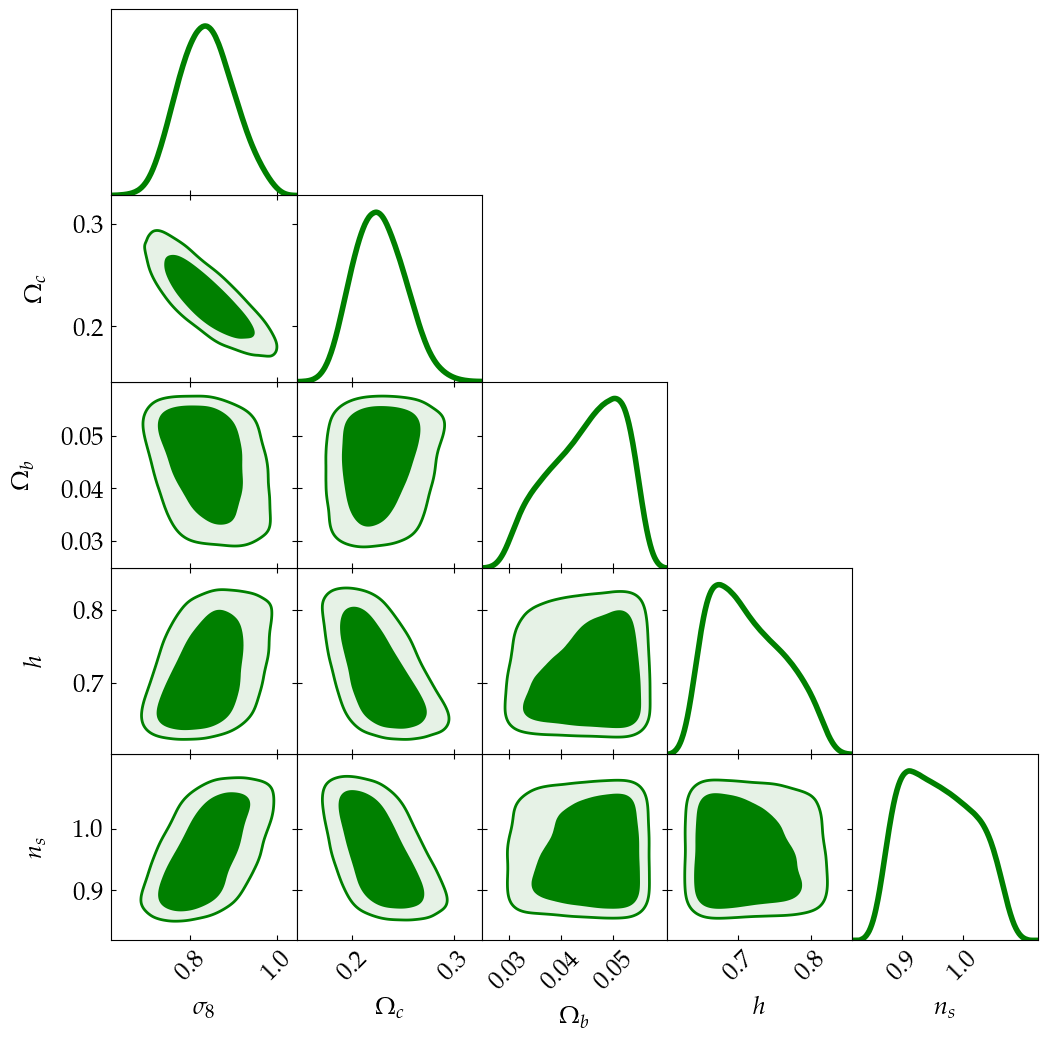

In [13]:
triangle_plot(samples_jaxcosmo[0][:,0:5], labels_cosmo)